In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import svm
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
# references:
# overfitting - https://machinelearningmastery.com/overfitting-machine-learning-models/

In [2]:
train = pd.read_csv('../data/cases_train_processed.csv')

In [3]:
# convert male to 0 and female to 1
#train.replace(to_replace ="male", value = 0) 
train = train.replace(to_replace =["female","male"], value = [0,1]) 
train.head()

,age,sex,province,country,latitude,longitude,date_confirmation,outcome,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,44.0,1,Delhi,India,28.614740,77.209100,26.05.2020,recovered,238828.0,4907.0,201671.0,32250.0,"Delhi,India",1276.409575,0.020546
1,44.0,1,Uttar Pradesh,India,25.436090,81.847180,20.05.2020,hospitalized,342788.0,4869.0,270094.0,67825.0,"Uttar Pradesh,India",144.099577,0.014204
2,44.0,1,Maharashtra,India,18.504220,73.853020,26.05.2020,hospitalized,1167496.0,31791.0,834432.0,301273.0,"Maharashtra,India",948.072083,0.027230
3,24.0,0,Baden-Wurttemberg,Germany,48.120860,7.849500,15.03.2020,nonhospitalized,46779.0,1871.0,41228.0,3680.0,"Baden-Wurttemberg,Germany",422.592353,0.039997
4,44.0,1,Gujarat,India,23.188409,73.647122,20.05.2020,hospitalized,120336.0,3286.0,100974.0,16076.0,"Gujarat,India",188.400627,0.027307


In [4]:
train['date_confirmation'].unique()

array(['26.05.2020', '20.05.2020', '15.03.2020', '28.05.2020',
       '18.05.2020', '27.03.2020', '24.05.2020',
       '10.03.2020 - 12.03.2020', '10.05.2020', '29.05.2020',
       '03.05.2020', '30.05.2020', '16.05.2020', '27.05.2020',
       '13.04.2020', '31.05.2020', '02.05.2020', '14.04.2020',
       '21.05.2020', '02.06.2020', '31.03.2020', '07.05.2020',
       '28.03.2020', '24.04.2020', '09.04.2020', '26.04.2020',
       '22.04.2020', '01.06.2020', '08.05.2020', '23.05.2020',
       '13.05.2020', '05.04.2020', '06.05.2020', '16.04.2020',
       '19.05.2020', '05.06.2020', '25.04.2020', '21.04.2020',
       '25.05.2020', '07.04.2020', '11.05.2020', '14.05.2020',
       '17.05.2020', '15.05.2020', '27.04.2020', '19.04.2020',
       '04.05.2020', '26.03.2020', '22.05.2020', '13.03.2020',
       '23.04.2020', '12.05.2020', '09.05.2020', '30.04.2020',
       '03.04.2020', '13.06.2020', '20.03.2020', '05.05.2020',
       '12.04.2020', '10.04.2020', '04.03.2020', '02.04.2020',
       

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319639 entries, 0 to 319638
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  319639 non-null  float64
 1   sex                  319639 non-null  int64  
 2   province             319639 non-null  object 
 3   country              319639 non-null  object 
 4   latitude             319639 non-null  float64
 5   longitude            319639 non-null  float64
 6   date_confirmation    319639 non-null  object 
 7   outcome              319639 non-null  object 
 8   Confirmed            273717 non-null  float64
 9   Deaths               273717 non-null  float64
 10  Recovered            273717 non-null  float64
 11  Active               273717 non-null  float64
 12  Combined_Key         273717 non-null  object 
 13  Incidence_Rate       273717 non-null  float64
 14  Case-Fatality_Ratio  273717 non-null  float64
dtypes: float64(9), in

In [7]:
def filterDateConfirmation(df):
    for index, row in df.iterrows():
        if '-' in str(row['date_confirmation']):
            split_date = str(row['date_confirmation']).split('-')
            
            # Get first date in range
            first_date = split_date[0].strip()
            
            # Convert date to epoch timestamp
            utc_time = datetime.strptime(first_date, "%d.%m.%Y")
            epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
        else:
            # Convert date to epoch timestamp
            utc_time = datetime.strptime(row['date_confirmation'], "%d.%m.%Y")
            epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
            
            df.at[index, 'timestamp'] = epoch_time
    return df

train = filterDateConfirmation(train)

In [8]:
# Functions below will fill up the nan value depending on attribute.
# age by average because we can easily find the average since all ages are now integers.
def nanByAverage(df):
    
    notnan = df[df['Confirmed'].isnull()==False]
    avg = round(notnan['Confirmed'].astype(int).sum()/len(notnan))
    print(avg)
    df['Confirmed'] = df['Confirmed'].fillna(avg)
   
    notnan = df[df['Deaths'].isnull()==False]
    avg = round(notnan['Deaths'].astype(int).sum()/len(notnan))
    print(avg)
    df['Deaths'] = df['Deaths'].fillna(avg)
    
    notnan = df[df['Recovered'].isnull()==False]
    avg = round(notnan['Recovered'].astype(int).sum()/len(notnan))
    print(avg)
    df['Recovered'] = df['Recovered'].fillna(avg)
    
    notnan = df[df['Active'].isnull()==False]
    avg = round(notnan['Active'].astype(int).sum()/len(notnan))
    print(avg)
    df['Active'] = df['Active'].fillna(avg)
    
    notnan = df[df['Incidence_Rate'].isnull()==False]
    avg = round(notnan['Incidence_Rate'].astype(int).sum()/len(notnan))
    print(avg)
    df['Incidence_Rate'] = df['Incidence_Rate'].fillna(avg)
    
    notnan = df[df['Case-Fatality_Ratio'].isnull()==False]
    avg = round(notnan['Case-Fatality_Ratio'].astype(int).sum()/len(notnan))
    print(avg)
    df['Case-Fatality_Ratio'] = df['Case-Fatality_Ratio'].fillna(avg)
    
    notnan = df[df['timestamp'].isnull()==False]
    avg = round(notnan['timestamp'].astype(int).sum()/len(notnan))
    print(avg)
    df['timestamp'] = df['timestamp'].fillna(avg)
    
    return df

train = nanByAverage(train)
train['timestamp'].unique()

483526.0
12661.0
336899.0
133967.0
946.0
0.0
1589084735.0


array([1.59045120e+09, 1.58993280e+09, 1.58423040e+09, 1.59062400e+09,
       1.58976000e+09, 1.58526720e+09, 1.59027840e+09, 1.58908474e+09,
       1.58906880e+09, 1.59071040e+09, 1.58846400e+09, 1.59079680e+09,
       1.58958720e+09, 1.59053760e+09, 1.58673600e+09, 1.59088320e+09,
       1.58837760e+09, 1.58682240e+09, 1.59001920e+09, 1.59105600e+09,
       1.58561280e+09, 1.58880960e+09, 1.58535360e+09, 1.58768640e+09,
       1.58639040e+09, 1.58785920e+09, 1.58751360e+09, 1.59096960e+09,
       1.58889600e+09, 1.59019200e+09, 1.58932800e+09, 1.58604480e+09,
       1.58872320e+09, 1.58699520e+09, 1.58984640e+09, 1.59131520e+09,
       1.58777280e+09, 1.58742720e+09, 1.59036480e+09, 1.58621760e+09,
       1.58915520e+09, 1.58941440e+09, 1.58967360e+09, 1.58950080e+09,
       1.58794560e+09, 1.58725440e+09, 1.58855040e+09, 1.58518080e+09,
       1.59010560e+09, 1.58405760e+09, 1.58760000e+09, 1.58924160e+09,
       1.58898240e+09, 1.58820480e+09, 1.58587200e+09, 1.59200640e+09,
      

In [9]:
# we will remove province, country, and Combined_Key
train = train.drop(columns=['province','country','Combined_Key','date_confirmation'])

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319639 entries, 0 to 319638
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  319639 non-null  float64
 1   sex                  319639 non-null  int64  
 2   latitude             319639 non-null  float64
 3   longitude            319639 non-null  float64
 4   outcome              319639 non-null  object 
 5   Confirmed            319639 non-null  float64
 6   Deaths               319639 non-null  float64
 7   Recovered            319639 non-null  float64
 8   Active               319639 non-null  float64
 9   Incidence_Rate       319639 non-null  float64
 10  Case-Fatality_Ratio  319639 non-null  float64
 11  timestamp            319639 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 29.3+ MB


In [11]:
X = train.drop('outcome',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, train['outcome'], test_size=0.2, train_size=0.8, random_state=0)

In [12]:
train['outcome'].unique()

array(['recovered', 'hospitalized', 'nonhospitalized', 'deceased'],
      dtype=object)

In [13]:
X_train.head()

,age,sex,latitude,longitude,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,timestamp
262996,44.0,0,28.614740,77.209100,238828.0,4907.0,201671.0,32250.0,1276.409575,0.020546,1.590106e+09
187475,44.0,0,39.998630,8.705055,3167.0,141.0,1431.0,1595.0,193.157928,0.044522,1.588291e+09
92179,44.0,1,28.614740,77.209100,238828.0,4907.0,201671.0,32250.0,1276.409575,0.020546,1.590019e+09
203298,24.0,1,50.090178,12.042008,64465.0,2648.0,56398.0,5419.0,492.975265,0.041077,1.587686e+09
57285,44.0,1,28.614740,77.209100,238828.0,4907.0,201671.0,32250.0,1276.409575,0.020546,1.588810e+09


In [14]:
# we will graph out the accuracy score for k-neaerest neighbours for k=2 to 100

def knn_plotPrecision(cases_train,outcomes_train,cases_valid,outcomes_valid):
    valid_acc = []
    train_acc = []
    n_neighbors = [i for i in range(2,100,5)]
    for i in range(2,100,5):
        model=KNeighborsClassifier(n_neighbors=i, weights='distance')
        model.fit(cases_train,outcomes_train)
        valid_acc.append(model.score(cases_valid,outcomes_valid))
        train_acc.append(model.score(cases_train,outcomes_train))
    return valid_acc,train_acc

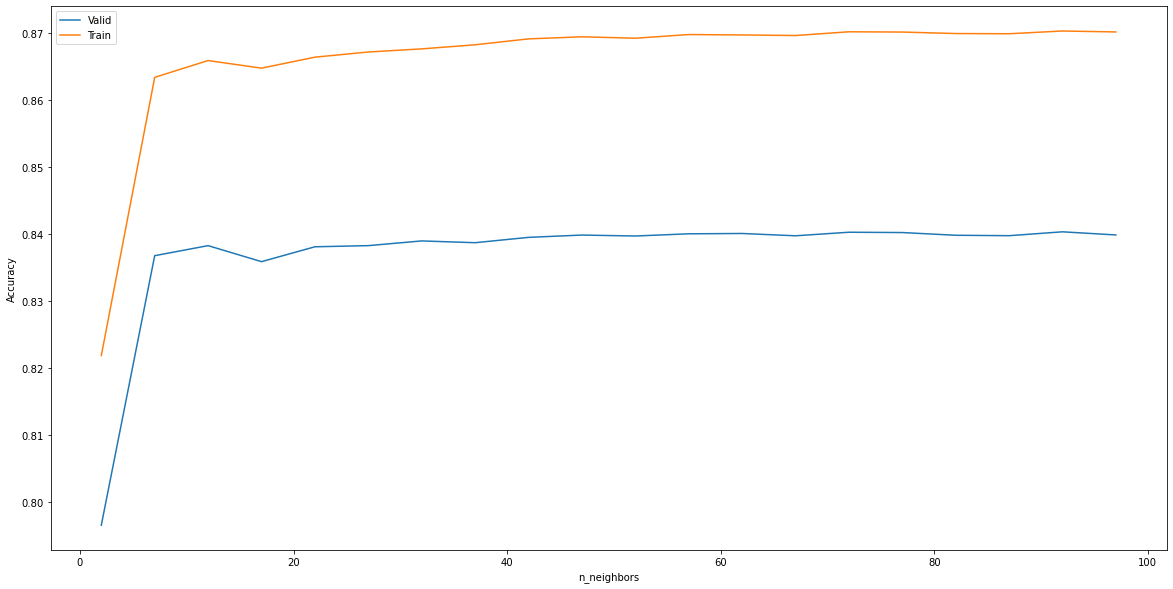

In [15]:
valid_acc,train_acc = knn_plotPrecision(X_train, y_train, X_test, y_test)
plt.figure(figsize=(20,10))
x = [i for i in range(2,100,5)]
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.plot(x,valid_acc, label = 'Valid')
plt.plot(x,train_acc, label = 'Train')
plt.legend()
plt.savefig('../plots/knn_tree_depth_plot.png')
plt.show()

In [ ]:
# we will graph out the accuracy score for random forest for depths up to 100

def rf_plotPrecision(cases_train, outcomes_train, cases_valid, outcomes_valid):
    precision_train = []
    precision_valid = []
    for i in range(1, 100, 5):
        model = RandomForestClassifier(max_features='log2', max_depth=i)
        model.fit(cases_train, outcomes_train)

        pred_train = model.predict(cases_train)
        prec_train = accuracy_score(outcomes_train, pred_train)
        precision_train.append(prec_train)

        pred_valid = model.predict(cases_valid)
        prec_valid = accuracy_score(outcomes_valid, pred_valid)
        precision_valid.append(prec_valid)
        
    return precision_train, precision_valid

In [ ]:
precision_train, precision_valid = rf_plotPrecision(X_train, y_train, X_test, y_test)

plt.figure(figsize=(20,10))
x = np.arange(1, 100, step=5)

plt.xlabel('Tree depth')
plt.ylabel('Accuracy')

plt.plot(x, precision_train, label='Train')
plt.plot(x, precision_valid, label='Valid')
plt.legend()
plt.savefig('../plots/rf_tree_depth_plot.png')
plt.show()

In [ ]:
# we will graph out the accuracy score for gradient boosting for depths up to 21
# note that this may take 4+ hours, so it's better to just look at the output plot in plots folder

def gb_plotPrecision(cases_train,outcomes_train,cases_valid,outcomes_valid):
    valid_acc = []
    train_acc = []
    max_depth = [i for i in range(1, 21)]
    for i in max_depth:
        model=GradientBoostingClassifier(max_depth=i, min_samples_leaf=2, random_state=0)
        model.fit(cases_train,outcomes_train)
        valid_acc.append(model.score(cases_valid,outcomes_valid))
        train_acc.append(model.score(cases_train,outcomes_train))
    return valid_acc,train_acc

In [ ]:
# plot of train and test scores vs tree depth
valid_acc,train_acc = gb_plotPrecision(X_train, y_train, X_test, y_test)
values = [i for i in range(1, 21)]
plt.figure(figsize=(20,10))
plt.plot(values, train_acc, label='Train')
plt.plot(values, valid_acc, label='Valid')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../plots/Gb_tree_depth_plot.png')
plt.show()

In [16]:
# our hyperparameters were chosen based on our elbow graphs for the max depths and n neighbors.
rf = RandomForestClassifier(max_depth=25, max_features='log2')
knn = KNeighborsClassifier(n_neighbors=12, weights='distance')
gbst = GradientBoostingClassifier(max_depth=11, min_samples_leaf=2, random_state=0)

model = VotingClassifier([
        ('rf', rf),
        ('knn', knn),
        ('Gboost', gbst)
    ])

In [17]:
# fit our models and export to the pickle files
rf.fit(X_train, y_train)
filename = '../models/rf_classifier.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf, file)

In [18]:
knn.fit(X_train, y_train)
filename = '../models/knn_classifier.pkl'
with open(filename, 'wb') as file:
    pickle.dump(knn, file)

In [ ]:
gbst.fit(X_train, y_train)
filename = '../models/GB_classifier.pkl'
with open(filename, 'wb') as file:
    pickle.dump(gbst, file)

In [ ]:
# load our models
knn_pkl = pickle.load(open("../models/knn_classifier.pkl", "rb"))
rf_pkl = pickle.load(open("../models/rf_classifier.pkl", "rb"))
gb_pkl = pickle.load(open("../models/GB_classifier.pkl", "rb"))

In [ ]:
# fit our knn model for training and predict for our testing and training data
#knn_pkl.fit(X_train, y_train)
knn_y_pred_test = knn_pkl.predict(X_test)
print(accuracy_score(y_test, knn_y_pred_test))

In [ ]:
knn_y_pred_train = knn_pkl.predict(X_train)
print(accuracy_score(y_train, knn_y_pred_train))

In [ ]:
# fit our random forest model for training and predict for our testing and training data
#rf_pkl.fit(X_train, y_train)
rf_y_pred_test = rf_pkl.predict(X_test)
print(accuracy_score(y_test, rf_y_pred_test))

In [ ]:
rf_y_pred_train = rf_pkl.predict(X_train)
print(accuracy_score(y_train, rf_y_pred_train))

In [ ]:
# fit our gradient boosting model for training and predict for our testing and training data
#gb_pkl.fit(X_train, y_train)
gb_y_pred_test = gb_pkl.predict(X_test)
print(accuracy_score(y_test, gb_y_pred_test))

In [ ]:
gb_y_pred_train = gb_pkl.predict(X_train)
print(accuracy_score(y_train, gb_y_pred_train))